# 📊 Capstone Project: Stock Portfolio Recommendation

## 1. Project Description and Objective
I am working as a wealth manager at a small firm where I have clients seeking advice on how to invest their money.  
A young client wants to invest a large amount of their savings in a portfolio of stocks, but they are unsure of what stocks to invest in and at what amounts.  

In this capstone project, I will create a presentation that showcases a portfolio of stocks that I recommend the client invest in, and provide the weights at which they should invest in each stock depending on their risk preference.

The purpose of this capstone is to practice accessing and downloading financial data, calculating financial statistics to understand the individual performance of an asset and how groups of assets are related, and how to allocate investments across assets for optimal performance.


<span style="color: blue; font-weight: bold;">INSTALLATION & IMPORT MODULES</span>

In [92]:
# Import modules and libraries 
!pip install cvxopt
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime, timedelta
import yfinance as yf
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
from scipy.optimize import minimize


<span style="color: blue; font-weight: bold;">COLLECT FINANCIAL DATA</span>

In [13]:
# 2. Define parameters
tickers = ["AAPL", "MSFT", "NVDA", "AMZN", "GOOGL"]  
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
RISK_FREE_RATE = 0.04 

In [14]:
# 3. Data Collection
raw_data = yf.download(tickers, start=START_DATE, end=END_DATE, progress=False,auto_adjust=False)

# Handle "Adj Close" vs "Close"
if "Adj Close" in raw_data:
    stock_data = raw_data["Adj Close"]
else:
    stock_data = raw_data["Close"]

# Remove tickers with no data
data = data.dropna(axis=1, how="all")

if data.empty:
    raise Exception("No valid data returned. Please check ticker symbols.")
stock_data.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Date,,,,,
2020-01-02,72.538490,94.900497,68.026024,153.042267,5.971746
2020-01-03,71.833298,93.748497,67.670158,151.136627,5.876163
2020-01-06,72.405685,95.143997,69.473846,151.527298,5.900805
2020-01-07,72.065147,95.343002,69.339645,150.145752,5.972245
2020-01-08,73.224411,94.598503,69.833183,152.537308,5.983446


<span style="color: blue; font-weight: bold;">PART II</span>


<span style="color: red;">Plot the adjusted closing prices over time</span>

<Figure size 1200x900 with 0 Axes>

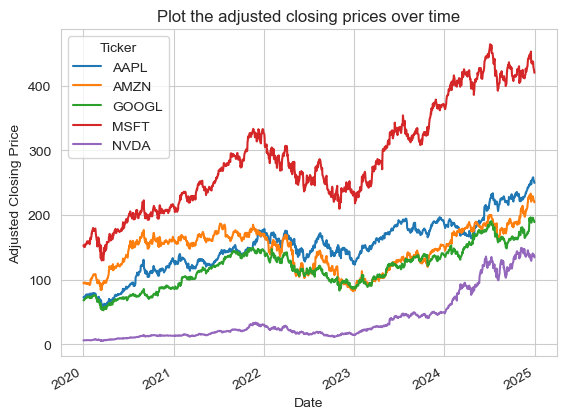

<function matplotlib.pyplot.clf() -> 'None'>

In [122]:
sns.set_style('whitegrid')
plt.figure(figsize = (12,9))
stock_data.plot()
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.title("Plot the adjusted closing prices over time")
plt.savefig("adjusted_closing_price.png", dpi=300, transparent=True)
plt.show()
plt.clf


<span style="color: red;">Daily Simple Rate of Return Over Time</span>

<Figure size 1200x600 with 0 Axes>

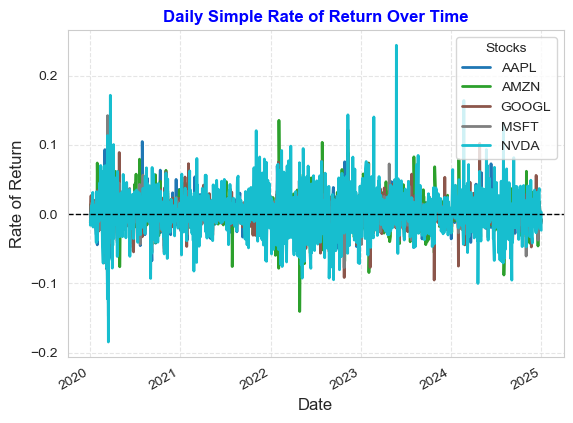

In [124]:
returns=stock_data.pct_change().dropna()
plt.figure(figsize=(12,6))
returns.plot(linewidth=2, colormap='tab10')
plt.title('Daily Simple Rate of Return Over Time', fontsize=12, fontweight='bold', color='blue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rate of Return', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.legend(title='Stocks', fontsize=10)
plt.savefig("daily_simple_rate.png", dpi=300, transparent=True)
plt.show()

<span style="color: red;">The Daily Simple Rates of Return Over Time Per Stock</span>

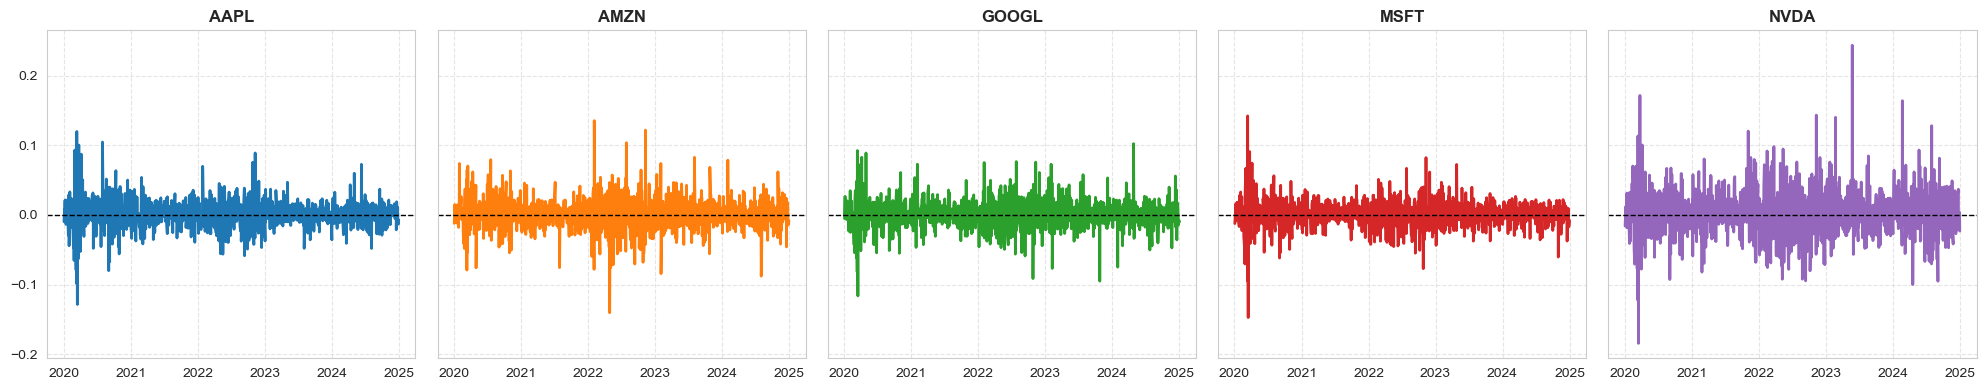

In [126]:
fig, axes = plt.subplots(1, 5, figsize=(20,4), sharey=True)

# color palette (tab10)
colors = plt.get_cmap('tab10').colors

# subplots for each stock
for i, ticker in enumerate(tickers):
    axes[i].plot(returns[ticker], color=colors[i], linewidth=2)
    axes[i].set_title(ticker, fontsize=12, fontweight='bold')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    axes[i].axhline(0, color='black', linewidth=1, linestyle='--')  # 0 referans çizgisi

# Layout
plt.tight_layout()
plt.savefig("daily_simple_rate_each_asset.png", dpi=400, transparent=True)
plt.show()

<span style="color: blue; font-weight: bold;"> ANALYZE INDIVIDIAL ASSETS </span>


<span style="color: red;">Calculate and plot the mean of each stock's daily simple rate of return.</span>

In [45]:
mean_returns = returns.mean()
mean_returns = mean_returns.reset_index()
mean_returns.columns = ['Ticker', 'Mean']  # directly assign column names
mean_returns

,Ticker,Mean
0,AAPL,0.001182
1,AMZN,0.000923
2,GOOGL,0.001022
3,MSFT,0.000988
4,NVDA,0.003050


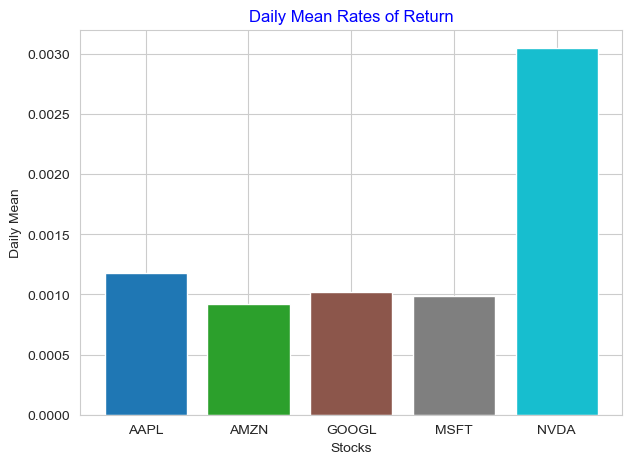

In [128]:
#colors = plt.cm.get_cmap('tab10') 
colors = plt.get_cmap('tab10')
bar_colors = colors(np.linspace(0, 1, len(mean_returns)))

plt.figure(figsize=(7,5))
plt.bar(mean_returns['Ticker'], mean_returns['Mean'], color=bar_colors)
plt.xlabel("Stocks", fontsize = 10)
plt.ylabel("Daily Mean", fontsize = 10)
plt.title("Daily Mean Rates of Return", fontsize = 12,color='blue')
plt.savefig("daily_mean_rate.png", dpi=300, transparent=True)
plt.show()

<span style="color: red;">Calculate and plot the **Standard deviation(Volatilite)**</span>

In [61]:
returns_std = returns.std()
returns_std = returns_std.reset_index()
returns_std.columns = ['Ticker','Std']
returns_std

,Ticker,Std
0,AAPL,0.019956
1,AMZN,0.022655
2,GOOGL,0.020472
3,MSFT,0.019211
4,NVDA,0.033940


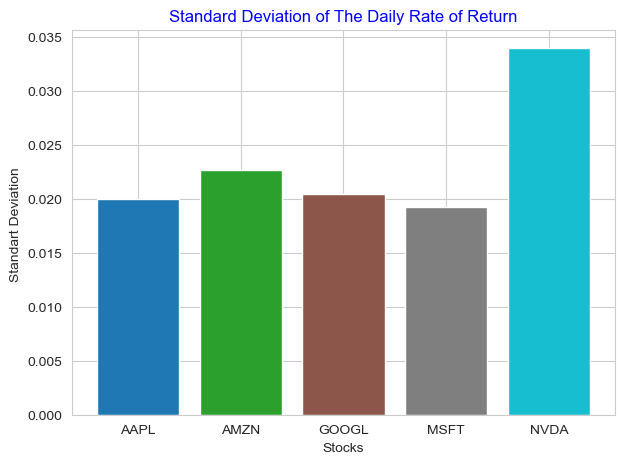

In [130]:
colors = plt.get_cmap('tab10')
bar_colors = colors(np.linspace(0, 1, len(returns_std)))

plt.figure(figsize=(7,5))
plt.bar(returns_std['Ticker'], returns_std['Std'], color=bar_colors)
plt.xlabel("Stocks", fontsize = 10)
plt.ylabel("Standart Deviation ", fontsize = 10)
plt.title("Standard Deviation of The Daily Rate of Return", fontsize = 12,color='blue')
plt.savefig("standart_dev_rate.png", dpi=300, transparent=True)
plt.show()

<span style="color: red;">Calculate and plot the **variance**</span>

In [59]:
returns_var = returns.var()
returns_var = returns_var.reset_index()
returns_var.columns = ['Ticker','Var']
returns_var

,Ticker,Var
0,AAPL,0.000398
1,AMZN,0.000513
2,GOOGL,0.000419
3,MSFT,0.000369
4,NVDA,0.001152


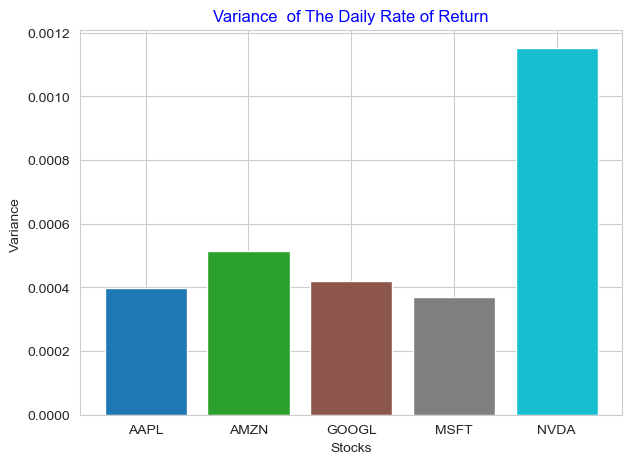

In [132]:
colors = plt.get_cmap('tab10')
bar_colors = colors(np.linspace(0, 1, len(returns_var)))

plt.figure(figsize=(7,5))
plt.bar(returns_var['Ticker'], returns_var['Var'], color=bar_colors)
plt.xlabel("Stocks", fontsize = 10)
plt.ylabel("Variance ", fontsize = 10)
plt.title("Variance  of The Daily Rate of Return", fontsize = 12,color='blue')
plt.savefig("variance_rate.png", dpi=300, transparent=True)
plt.show()

<span style="color: red;">Calculate and plot the **Correlation**</span>

In [68]:
corr_matrix = returns.corr()
corr_matrix

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Ticker,,,,,
AAPL,1.000000,0.592200,0.648932,0.748327,0.606399
AMZN,0.592200,1.000000,0.647196,0.678500,0.579744
GOOGL,0.648932,0.647196,1.000000,0.746181,0.594137
MSFT,0.748327,0.678500,0.746181,1.000000,0.682141
NVDA,0.606399,0.579744,0.594137,0.682141,1.000000


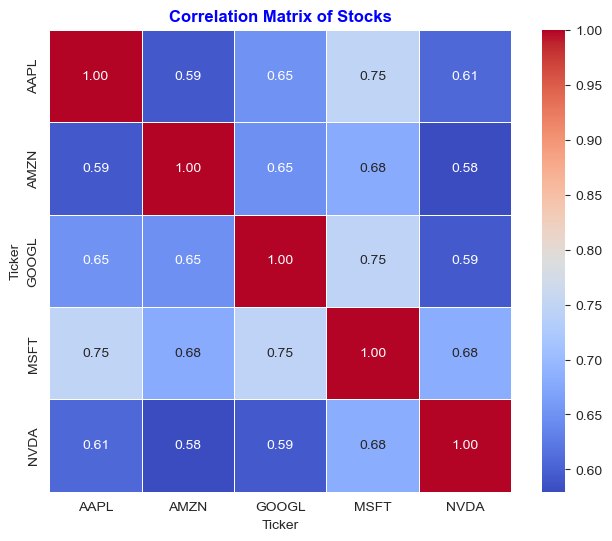

In [134]:
corr_matrix = returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,        # show values into cell
    fmt=".2f",         #  format
    cmap="coolwarm",   # color palette 
    linewidths=0.5,    # line between cells
    square=True        # square cells  
)

plt.title("Correlation Matrix of Stocks", fontsize=12, fontweight='bold',color ='blue')
plt.savefig("correlation_matrix .png", dpi=300, transparent=True)
plt.show()

<span style="color: red;">Calculate and plot the **Covariance**</span>

In [79]:
cov_matrix = returns.cov()
cov_matrix

Ticker,AAPL,AMZN,GOOGL,MSFT,NVDA
Ticker,,,,,
AAPL,0.000398,0.000268,0.000265,0.000287,0.000411
AMZN,0.000268,0.000513,0.000300,0.000295,0.000446
GOOGL,0.000265,0.000300,0.000419,0.000293,0.000413
MSFT,0.000287,0.000295,0.000293,0.000369,0.000445
NVDA,0.000411,0.000446,0.000413,0.000445,0.001152


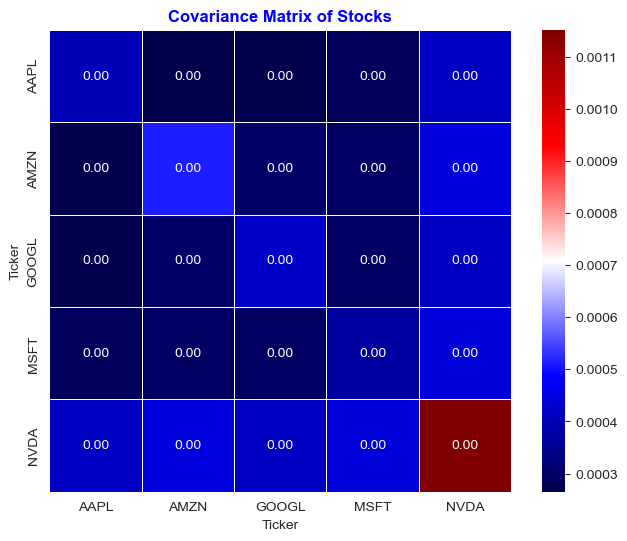

In [138]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    cov_matrix, 
    annot=True,        # show value into cell 
    fmt=".2f",         # format
    cmap="seismic",    # color palette 
    linewidths=0.5,    # line between cells
    square=True        # square hücreler
)

plt.title("Covariance Matrix of Stocks", fontsize=12, fontweight='bold',color ='blue')
plt.savefig("covariance_matrix.png", dpi=300, transparent=True)
plt.show()

<span style="color: blue; font-weight: bold;"> PORTFOLIO OPTIMIZATION </span>

In [112]:

# Risk-free rate
risk_free_rate = 0.02

# Portfoy performance
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.sum(weights * mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_std

# Random portfoy simulation
def simulate_portfolios(mean_returns, cov_matrix, num_portfolios=5000, risk_free_rate=0.02):
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)

        port_return, port_std = portfolio_performance(weights, mean_returns, cov_matrix)
        sharpe = (port_return - risk_free_rate) / port_std

        results[0,i] = port_return
        results[1,i] = port_std
        results[2,i] = sharpe

    return results, weights_record

# Run Simülataion
results, weights_record = simulate_portfolios(mean_returns_array, cov_matrix_array, 5000, risk_free_rate)

# Max Sharpe ve Min Vol portfoy 
max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[1])

max_sharpe = results[:, max_sharpe_idx]
min_vol = results[:, min_vol_idx]



<span style="color: red;">Efficient Frontier </span>

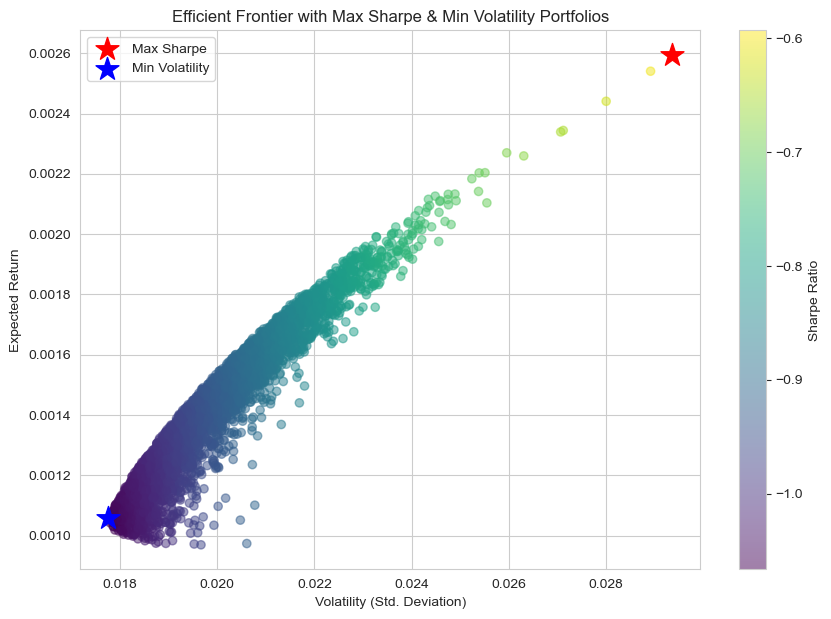

In [137]:
# Efficient Frontier grafiği
plt.figure(figsize=(10,7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe[1], max_sharpe[0], marker='*', color='r', s=300, label='Max Sharpe')
plt.scatter(min_vol[1], min_vol[0], marker='*', color='b', s=300, label='Min Volatility')
plt.title('Efficient Frontier with Max Sharpe & Min Volatility Portfolios')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.savefig("efficient_frontier.png", dpi=300, transparent=True)
plt.show()


<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

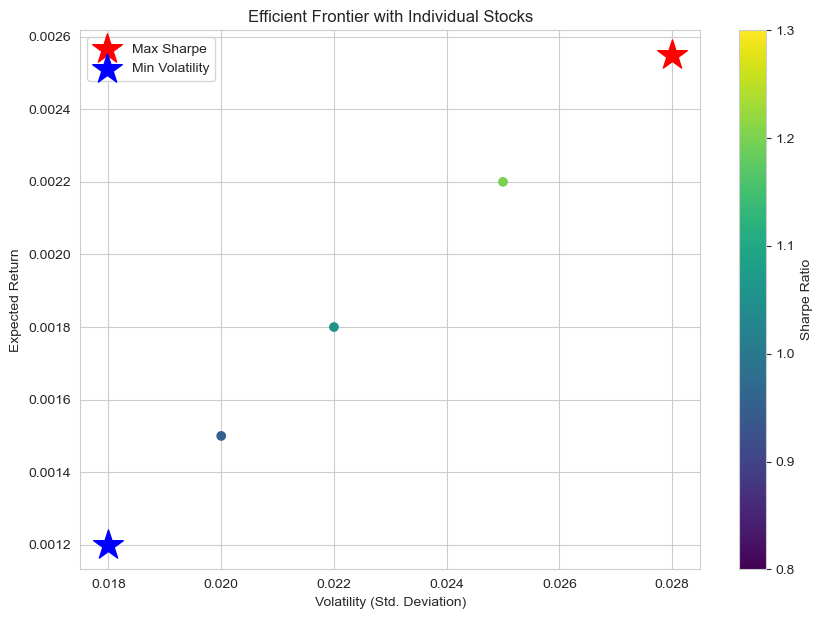

In [119]:

# Örnek: kendi verilerini buraya koy
# Bunlar tek boyutlu olmalı (1D array)
volatilities = np.array([0.018, 0.020, 0.022, 0.025, 0.028]).flatten()
expected_returns = np.array([0.0012, 0.0015, 0.0018, 0.0022, 0.00255]).flatten()
sharpe_ratios = np.array([0.8, 0.95, 1.05, 1.2, 1.3]).flatten()

# Max Sharpe & Min Vol değerleri (örnek)
max_sharpe_vol = volatilities[np.argmax(sharpe_ratios)]
max_sharpe_ret = expected_returns[np.argmax(sharpe_ratios)]
min_vol_vol = volatilities[np.argmin(volatilities)]
min_vol_ret = expected_returns[np.argmin(volatilities)]




# Grafik
plt.figure(figsize=(10, 7))
scatter = plt.scatter(volatilities, expected_returns, 
                      c=sharpe_ratios, cmap='viridis', marker='o')

# Max Sharpe portföyü (kırmızı yıldız)
plt.scatter(max_sharpe_vol, max_sharpe_ret, 
            marker='*', color='r', s=500, label='Max Sharpe')

# Min Vol portföyü (mavi yıldız)
plt.scatter(min_vol_vol, min_vol_ret, 
            marker='*', color='b', s=500, label='Min Volatility')

plt.title('Efficient Frontier with Individual Stocks')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.legend()
plt.show()



<span style="color: grey;">The chart illustrates the distribution of portfolios along the efficient frontier. The color scale represents the Sharpe ratio. The red star marks the portfolio with the highest Sharpe ratio (most efficient in terms of risk-return), while the blue star marks the portfolio with the lowest volatility. The maximum Sharpe portfolio offers higher returns with relatively higher volatility, whereas the minimum volatility portfolio features lower returns and lower risk. This distribution clearly shows the range of portfolio choices available to investors depending on their risk tolerance.</span>

